In [21]:
import os
import json 
from itertools import islice
from tqdm import tqdm
import numpy as np
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

### Parameters for invoking the notebook

- `cskg_connected`: a tsv file contains the raw cskg entity information
- `cskg_lexicalized`: a tsv file contains the lexicalized edges
- `edge_embeddings.tsv.`: a tsv file contains the edges embeddings and edge id
- `log_path`: a folder keeps tensorboard projector's configuration

In [3]:
cskg_connected = '../input/cskg_connected.tsv'
cskg_lexicalized = '../output/cskg_lexicalized.tsv'
edge_embeddings = '../output/edge_embeddings.tsv'
log_path = '../output/log'

###  Load cskg_connected.tsv and retrieve usefor info

In [4]:
### load cskg label and relation
def cskg_lexicalize(input_file): # cskg_connected.tsv   
    cskg_info = []
    with open(input_file) as f:
        for line in islice(f, 1, None): # ignore first line 
            content = line.split('\t')
            id_=  content[0]
            res_meta = content[2]
            node1_lbl = content[4]
            node2_lbl = content[5]
            res_lbl = content[6]
            sentence = content[-1].replace('\n','')
            
            reterive = lambda x: x.split('|')[0]
            node1_lbl = reterive(node1_lbl)
            node2_lbl = reterive(node2_lbl)
            res_lbl = reterive(res_lbl)
            
            if node1_lbl == '' or node2_lbl == '' or res_lbl== '' or sentence =='':
                # if one of them is empty, then skip the edge. I
                continue                
            cskg_info.append((id_,node1_lbl,res_lbl,node2_lbl,res_meta,sentence))         
    return cskg_info 

# store res metadata and label infomation
def rel_info(cskg_info):
    rel_meta_dict = {}
    rel_lbl_dict = {}
    
    for line in cskg_info:
        rel_meta = line[-2]  # example: '/r/Is a'
        rel_label = line[2]  # example: 'is a '
        rel_lbl_dict[rel_label] = rel_lbl_dict.get(rel_label,0)+1
        rel_meta_dict[rel_meta] = rel_meta_dict.get(rel_meta,{})
        rel_meta_dict[rel_meta][rel_label] = rel_lbl_dict[rel_label]      
    return rel_meta_dict

In [5]:
## puzzle1 : too many missing value
# here is the counting for how many sentences are null
count = 0
with open(cskg_connected) as f:
    for line in islice(f, 1, None): # ignore first line 
        content=line.split('\t')
        if content[-1] == '\n':
            count+=1  
count

5398469

In [6]:
cskg_info = cskg_lexicalize(cskg_connected)
print('edge_id, node1_label, relation_label, node2_label, , relation_meta, sentence')
print(cskg_info[0])
print(f'size of cskg_info: {len(cskg_info)}')

edge_id, node1_label, relation_label, node2_label, , relation_meta, sentence
('/c/en/0.22_inch_calibre-/r/IsA-/c/en/5.6_millimetres-0000', '0.22 inch calibre', 'is a', '5.6 millimetres', '/r/IsA', '[[0.22 inch calibre]] is [[5.6 millimetres]]')
size of cskg_info: 604768


In [7]:
rel_meta_dict = rel_info(cskg_info)
len(rel_meta_dict)

33

### create template for cskg relations

In [8]:
rel_template = {
    '/r/IsA': 'is a',
    '/r/SimilarTo': 'is similar to',
    '/r/Synonym': 'is same as',
    '/r/Antonym': 'is opposite to',
    '/r/RelatedTo': 'is related to',
    '/r/FormOf': 'is form of',
    '/r/AtLocation': 'is located at',
    '/r/DerivedFrom': 'is derived from',
    '/r/HasProperty': 'has property',
    '/r/DefinedAs': 'is defined as',
    '/r/EtymologicallyRelatedTo': 'is etymologically related to',
    '/r/InstanceOf': 'is a', # == '/r/IsA'
    '/r/dbpedia/genre': 'is a type of',
    '/r/CapableOf': 'is able to',
    '/r/PartOf': 'is a part of',
    '/r/MadeOf': 'is made of',
    '/r/ReceivesAction': 'can receive the action',
    '/r/HasA': 'has a',
    '/r/UsedFor': 'is used for',
    '/r/NotHasProperty': 'not has property',
    '/r/CausesDesire': 'causes desire to',
    '/r/dbpedia/occupation': 'occupation is', # career
    '/r/dbpedia/language': 'language is',
    '/r/HasSubevent': 'can have event',
    '/r/HasContext':'has context',
    '/r/LocatedNear':'is located near', ## .... lots of subpro ...????
    '/r/DistinctFrom': 'is different from',
    '/r/dbpedia/influencedBy': 'is influenced by',
    '/r/MannerOf': 'is manner of',
    'mw:MayHaveProperty': 'may have property', # similar to has property
    '/r/Entails': 'entails', # similat to cause
    '/r/dbpedia/field': 'belongs to field of',
    '/r/dbpedia/genus': 'belongs to genus of',
    '/r/HasPrerequisite': 'has prerequisite of',
    '/r/dbpedia/capital':"'s capital is",
    '/r/NotCapableOf': 'is not able to',
    '/r/dbpedia/product': 'is product of',
    '/r/MotivatedByGoal': 'is motivated by goal',
    '/r/Desires': 'desire to',
    '/r/Causes':'causes',
    '/r/HasFirstSubevent': 'starts with',
    '/r/HasLastSubevent': 'ends with',
    '/r/NotDesires': 'doest not desire to',
    '/r/dbpedia/knownFor':'is known for',
    '/r/CreatedBy': 'is created by',
    '/r/dbpedia/leader': 'has the leader',
    '/r/EtymologicallyDerivedFrom': 'is etymologically derived from',
    '/r/SymbolOf': 'is symbol of', # similar to 'is'
    'at:xAttr': 'has attribute',
    'at:xEffect': 'causes', # same as  '/r/Causes'
    'at:xIntent': 'wants to',
    'at:xReact':'feels',
    'at:xWant': 'wants to',
    'at:oReact': 'feels',
    'at:oWant': 'wants to',
    'at:xNeed' : 'needs',
    'at:oEffect': 'causes',
    'fn:HasFrameElement':'has frame element',
    'fn:HasLexicalUnit': 'has lexical unit',
    'fn:InheritsFrom': 'inherits from',
    'fn:IsInheritedBy' : 'is inherited by',
    'fn:IsUsedBy': 'is used by',
    'fn:PerspectiveOn': 'has perspective on',
    'fn:Uses': 'uses',
    'fn:IsPerspectivizedIn': 'is perspectivized in',
    'fn:Precedes':'precedes',
    'fn:SubframeOf': 'is subframe of',
    'fn:IsPrecededBy': 'is preceded by',
    'fn:ReframingMapping': 'reframing mapping',
    'fn:HasSubframe': 'has subframe',
    'fn:SeeAlso': 'see also',
    'fn:IsCausativeOf': 'causes', # same as  '/r/Causes'
    'fn:IsInchoativeOf': 'is inchoative of', # a little bit like 'cause'
    'fn:Metaphor': 'is similar to', # same as similar to
    'fn:HasSemType': 'has sem type', # same type???
    'fn:fe:ExcludesFE': 'excludes fe',# ?
    'fn:fe:RequiresFE': 'requires fe',
    'fn:st:RootType': "'s root type is",
    'fn:st:SuperType': "'s super type is",
    'fn:st:SubType': "'s sub type is",
}

###  Represent each of the edges in TSV format
    * edge_id   lexicalization   sentence   
    
puzzle : which format shoud I use? {edge_id}    lexicalization   {sentence} or edge_id   lexicalization   sentence   

In [9]:
def create_cskg_lexi(cskg_info,rel_template,output_file):
    edge_info = []
    with open(output_file,'w') as f:   
        for edge in cskg_info:
            edge_id = edge[0]
            res_meta = edge[4]
            lexicalization = rel_template[res_meta]
            sentence = edge[-1]
            
            f.write(f"{edge_id}\t")  #  f.write(f"{{{edge_id}}}\t")
            f.write(f"{lexicalization}\t")
            f.write(f"{sentence}\n")  # f.write(f"{{{sentence}}}\n")
            edge_info.append((edge_id,lexicalization,sentence))
    return edge_info

In [10]:
edge_info = create_cskg_lexi(cskg_info,rel_template,cskg_lexicalized)
edge_info[0]

('/c/en/0.22_inch_calibre-/r/IsA-/c/en/5.6_millimetres-0000',
 'is a',
 '[[0.22 inch calibre]] is [[5.6 millimetres]]')

### Compute sentence embeddings of each of the sentences. 
 * model usage: bert-nli-large model
 * data usage: cskg_lexicalized

In [12]:
# use the pre-trained model bert-base-nli-mean-tokens
model = SentenceTransformer('bert-base-nli-mean-tokens')

In [13]:
# prepare all sentences
sentences = [ i[-1].replace('[[','').replace(']]','') for i in edge_info]
sentences[0]

'0.22 inch calibre is 5.6 millimetres'

In [14]:
%%time
# opearate sentence embedding
sentence_embeddings = model.encode(sentences)

CPU times: user 6min 46s, sys: 29.6 s, total: 7min 15s
Wall time: 7min 15s


In [15]:
# output embedding result
def gen_edge_embed(edge_info, sentence_embeddings,output_file):
    # format edge_id   edge-embedding   embedding
    edge_embedding = []
    fout = open(output_file,'w')   
    tag = 'edge-embedding'
    for edge, embedding in zip(edge_info, sentence_embeddings):
        id_ = edge[0]
        value = [str(float(i)) for i in embedding]
        value = ','.join(value)
        fout.write(id_+'\t')
        fout.write(tag+'\t')
        fout.write(value+'\n') 
        edge_embedding.append((id_,embedding))
        
    fout.close()
    return edge_embedding

In [16]:
%%time 
edge_embedding = gen_edge_embed(edge_info, sentence_embeddings,edge_embeddings)

CPU times: user 6min 30s, sys: 11.9 s, total: 6min 42s
Wall time: 6min 42s


### Cluster edges 

In [19]:
# build training data 
edge_list = [edge[0] for edge in edge_embedding]  # keep each edge's id
X_train = [edge[1] for edge in edge_embedding]    # keep each edge's embeddings

In [20]:
%%time
#fit the model
model = KMeans(n_clusters=13,init='k-means++',verbose=0)
model.fit(X_train)
pred_labels = model.labels_

CPU times: user 1h 39min 25s, sys: 11min 51s, total: 1h 51min 17s
Wall time: 3min 35s


In [22]:
## Use pca to do dimension reduction and visualize the result 
pca = PCA(n_components=2) 
X_pca = pca.fit_transform(X_train)

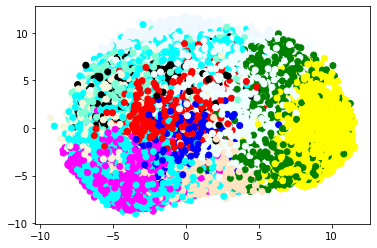

In [23]:
colors=['blue','green','red','cyan','magenta','yellow','black','aliceblue',
        'aqua','aquamarine','beige','azure','bisque']

col_map=dict(zip(set(pred_labels),colors))
label_color = [col_map[l] for l in pred_labels]

plt.scatter( X_pca[:,0], X_pca[:,1],c=label_color)
plt.show()

In [24]:
## summarize the cluster result
label_dict = {}
edge_num = len(pred_labels)
for label in pred_labels:
    label_dict[label] = label_dict.get(label,0)+1/edge_num
label_dict

{12: 0.052714429334902925,
 5: 0.1472085163235711,
 9: 0.06082663103870751,
 0: 0.08843060479396916,
 11: 0.08626283136680084,
 1: 0.03307549341234136,
 7: 0.03730521456161411,
 8: 0.06207339012649158,
 2: 0.0670918434838187,
 4: 0.1026558944918556,
 10: 0.058154531985844034,
 3: 0.12687013863177352,
 6: 0.07733048044875103}

### Using tensorflow projector to display visualization

In [31]:
def visualisation(edge_ids, embeddings, log_path):

    if not os.path.exists(log_path):
        os.mkdir(log_path)

    with tf.Session() as sess:
        # assign embeddings to tf var
        x = tf.Variable([0.0], name='edge embedding')
        place = tf.placeholder(tf.float32, shape=[len(edge_ids), len(embeddings[0])])

        set_x = tf.assign(x, place, validate_shape=False)
        sess.run(tf.global_variables_initializer())
        sess.run(set_x, feed_dict={place: embeddings})

        # store metedata to log path
        with open(log_path + '/metadata.tsv', 'w') as f:
            f.write('Edge ID\tCluster\n')
            for edge in edge_ids:
                edge_id = edge[0]
                edge_clusetr = edge[1]
                f.write(str(edge_id) + '\t' + str(edge_clusetr)+'\n' )

        # summary writing
        summary_writer = tf.summary.FileWriter(log_path)
        
        # projector configuration
        config = projector.ProjectorConfig()
        emb_conf = config.embeddings.add()
        emb_conf.tensor_name = x.name
        emb_conf.metadata_path = 'metadata.tsv'
        projector.visualize_embeddings(summary_writer, config)

        # save model.ckpt
        saver = tf.train.Saver()
        saver.save(sess, os.path.join(log_path, 'model.ckpt'), 1)

In [26]:
# wrap edge embeddings 
embeddings = []
edge_ids = []
for inde,edge in enumerate(edge_embedding):
    pred_label = pred_labels[inde]
    embeddings.append(edge[1])
    
    edge_ids.append((edge[0],pred_label))
embeddings = np.array(embeddings)
embeddings.shape,edge_ids[0]

((604768, 768),
 ('/c/en/0.22_inch_calibre-/r/IsA-/c/en/5.6_millimetres-0000', 12))

In [32]:
visualisation(edge_ids, embeddings, log_path)

* Use `tensorboard --logdir=log_path` to check visualization